In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import math

import umap
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

from scipy.stats import chi2

from config.regime_tickers import custom_vol_subset

# For Alpaca API
from datetime import datetime
from zoneinfo import ZoneInfo

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient

from alpaca.data.requests import (
    StockBarsRequest
)

from alpaca.data.enums import Adjustment

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# For API Keys
import os
from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [16]:
ticker_subsets = {
    'Equity_Indices': ['SPY', 'QQQ', 'IWM', 'DIA'],
    'Sectors': ['XLP', 'XLV', 'XLU'],
    'Global_Equities': ['EEM', 'EFA', 'FXI', 'EWZ'],
    'Bonds_Rates': ['TLT', 'IEF', 'SHY', 'HYG', 'LQD'],
    'Commodities': ['GLD', 'SLV', 'USO', 'DBA'],
    'Currencies': ['UUP', 'FXY', 'FXF', 'FXE', 'FXA', 'FXC']
}

all_tickers = sum(ticker_subsets.values(), [])

In [17]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
last_date = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

req = StockBarsRequest(
    symbol_or_symbols = all_tickers, 
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,  
    end = last_date,                  
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [18]:
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())

Total NANs: 0


In [19]:
# Trend feature functions
def compute_trend_features(df):
    df = df.sort_index()
    df['ret_5d'] = df['close'].pct_change(5)
    df['ret_20d'] = df['close'].pct_change(20)
    df['ma_10'] = df['close'].rolling(10).mean()
    df['ma_50'] = df['close'].rolling(50).mean()
    df['ma_200'] = df['close'].rolling(200).mean()
    df['ma_ratio_10_50'] = df['ma_10'] / df['ma_50'] - 1
    df['ma_ratio_10_200'] = df['ma_10'] / df['ma_200'] - 1
    df['rsi_14'] = compute_rsi(df['close'], 14)
    macd_data = compute_macd(df['close'])
    df['macd'] = macd_data['macd']
    df['macd_signal'] = macd_data['signal']
    df['macd_diff'] = df['macd'] - df['macd_signal']
    df['trend_strength'] = np.abs(df['ma_ratio_10_200']) * df['rsi_14']
    return df

def compute_rsi(series, period):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))

def compute_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, min_periods=short).mean()
    ema_long = series.ewm(span=long, min_periods=long).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    return pd.DataFrame({'macd': macd, 'signal': signal_line}, index=series.index)

# Apply feature extraction
features_by_subset = {}
for subset, tickers in ticker_subsets.items():
    df_subset = df_adj[df_adj['symbol'].isin(tickers)].copy()
    df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
    df_feat = df_feat.droplevel(0)  # remove groupby index level
    df_feat = df_feat.dropna()
    features_by_subset[subset] = df_feat

C:\Users\sergi\AppData\Local\Temp\ipykernel_18320\4260757392.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
C:\Users\sergi\AppData\Local\Temp\ipykernel_18320\4260757392.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
C:\Users\sergi\AppData\Local\Temp\ipykernel_18320\426075

In [20]:
# Combine all subsets
df_all = pd.concat(features_by_subset.values(), axis=0)
df_all = df_all.sort_index()

# Pivot wide
pivot_cols = ['ret_5d', 'ret_20d', 'ma_ratio_10_50', 'ma_ratio_10_200', 'rsi_14', 'macd_diff', 'trend_strength']
df_pivot = df_all.pivot_table(index=df_all.index, columns='symbol', values=pivot_cols)
df_pivot = df_pivot.dropna()

# Final smoothed 10 features
df_features = pd.DataFrame(index=df_pivot.index)

# 1. Mean 5-day return across equity indices
df_features['eq_idx_ret5d_mean'] = df_pivot['ret_5d'][['SPY', 'QQQ', 'IWM', 'DIA']].mean(axis=1)

# 2. Std of 20-day return across global equities
df_features['glob_eq_ret20d_std'] = df_pivot['ret_20d'][['EEM', 'EFA', 'FXI', 'EWZ']].std(axis=1)

# 3. Trend spread: max - min 10/200 MA ratio across sectors
df_features['sector_ma_ratio_spread'] = df_pivot['ma_ratio_10_200'][['XLP', 'XLV', 'XLU']].max(axis=1) - \
                                        df_pivot['ma_ratio_10_200'][['XLP', 'XLV', 'XLU']].min(axis=1)

# 4. RSI divergence: QQQ - SPY
df_features['rsi_diff_qqq_spy'] = df_pivot['rsi_14']['QQQ'] - df_pivot['rsi_14']['SPY']

# 5. Bond-equity trend divergence (LQD vs SPY)
df_features['macd_diff_lqd_spy'] = df_pivot['macd_diff']['LQD'] - df_pivot['macd_diff']['SPY']

# 6. Avg trend strength across commodities
df_features['commod_trend_strength'] = df_pivot['trend_strength'][['GLD', 'SLV', 'USO', 'DBA']].mean(axis=1)

df_features['sectors_trend_strength'] = df_pivot['trend_strength'][['XLP', 'XLV', 'XLU']].mean(axis=1)

# 7. Momentum dispersion across sectors (stdev of 10/50 MA ratio)
df_features['sector_momentum_dispersion'] = df_pivot['ma_ratio_10_50'][['XLP', 'XLV', 'XLU']].std(axis=1)

# 8. Global mean RSI across global equities (smooth replacement)
df_features['glob_eq_rsi_mean'] = df_pivot['rsi_14'][['EEM', 'EFA', 'FXI', 'EWZ']].mean(axis=1)

df_features['def_sector_eq_rsi_diff'] = df_pivot['rsi_14'][['XLP', 'XLV', 'XLU']].mean(axis=1) -\
                                  df_pivot['rsi_14'][['SPY', 'QQQ', 'IWM', 'DIA', 'EEM', 'EFA', 'FXI', 'EWZ']].mean(axis=1)


# 9. Currency-trend tilt: USD vs FXE
df_features['curr_def_vs_ret'] = df_pivot['ret_20d'][['UUP', 'FXY', 'FXF']].mean(axis=1) - \
                                      df_pivot['ret_20d'][['FXE', 'FXA', 'FXC']].mean(axis=1)

# 10. Equity trend consensus (mean MACD diff)
df_features['eq_idx_macd_diff_mean'] = df_pivot['macd_diff'][['SPY', 'QQQ', 'IWM', 'DIA']].mean(axis=1)

from scipy.stats import linregress

# 11. Volatility skew: std(20d ret) - std(5d ret) across global equities
ret_5d_glob = df_pivot['ret_5d'][['EEM', 'EFA', 'FXI', 'EWZ']]
ret_20d_glob = df_pivot['ret_20d'][['EEM', 'EFA', 'FXI', 'EWZ']]
vol_skew = ret_20d_glob.rolling(window=20).std() - ret_5d_glob.rolling(window=20).std()
df_features['glob_eq_vol_skew'] = vol_skew.mean(axis=1)

# 12. Commodity momentum slope: slope of 10-day returns linear fit for commodities
def slope_of_returns(series):
    x = np.arange(len(series))
    if len(series) < 10 or series.isnull().any():
        return np.nan
    slope, _, _, _, _ = linregress(x, series)
    return slope

# Compute rolling 10-day returns for commodities and apply slope function per timestamp
commodities = ['GLD', 'SLV', 'USO', 'DBA']
mom_slope = pd.DataFrame(index=df_pivot.index)

for c in commodities:
    mom_slope[c] = df_pivot['ret_5d'][c].rolling(window=10).apply(slope_of_returns, raw=False)

df_features['commod_momentum_slope'] = mom_slope.mean(axis=1)

eq_mom_slope = pd.DataFrame(index=df_pivot.index)
for c in ['SPY', 'QQQ', 'IWM', 'DIA']:
    eq_mom_slope[c] = df_pivot['ret_5d'][c].rolling(window=10).apply(slope_of_returns, raw=False)

df_features['eq_momentum_slope'] = eq_mom_slope.mean(axis=1)

df_features['eq_idx_ret5d_rebound'] = df_pivot['ret_5d'][['SPY', 'QQQ', 'IWM', 'DIA']].mean(axis=1).rolling(5).mean()

vol = df_pivot['ret_20d'][['EEM', 'EFA', 'FXI', 'EWZ']].std(axis=1)
df_features['glob_eq_vol_capped'] = np.clip(vol, a_min=None, a_max=vol.quantile(0.95))


# Drop any rows with NaNs introduced by rolling window
df_features = df_features.dropna()

# Updated final features dataframe: 12 total features
df_trend_factors = df_features.copy()


# Final DataFrame
df_trend_factors = df_features.copy()

In [21]:
from scipy.stats.mstats import winsorize

for col in df_trend_factors.columns:
    # Winsorize at the 0+limit% and 100-limit% quantiles
    df_trend_factors[col] = winsorize(df_trend_factors[col], limits=[0.01, 0.01])

In [22]:
df_trend_factors = df_trend_factors[[
 'eq_idx_ret5d_mean',
 'eq_momentum_slope',
 'def_sector_eq_rsi_diff',
 'glob_eq_rsi_mean',
 'curr_def_vs_ret'
 ]]

In [23]:
print(df_trend_factors.isna().sum().sum()) 

df_pivot_clean = df_trend_factors.copy()

0


In [24]:
N_COMP=3
N_NEIG=15
MIN_D = 0.01
METRIC = "correlation" 
K = 4

RANDOM_STATE = 0

In [25]:
RANDOM_STATE = 7
scaled = StandardScaler().fit_transform(df_pivot_clean)
X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(scaled)

silhouette_scores = []
ch_scores = []
db_scores = []

gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X_umap)

print({
    "silhouette": silhouette_score(X_umap, gmm_labels),
    "calinski_harabasz": calinski_harabasz_score(X_umap, gmm_labels),
    "davies_bouldin": davies_bouldin_score(X_umap, gmm_labels)
})

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'silhouette': 0.42739906907081604, 'calinski_harabasz': 2096.623291015625, 'davies_bouldin': 0.8388090580246776}


In [26]:
# ## Save scaler, umap, and gmm model
# import joblib

# # Define model directory
# MODEL_DIR = "models"
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Save the scaler
# scaler = MinMaxScaler().fit(df_pivot_clean)
# joblib.dump(scaler, os.path.join(MODEL_DIR, "vol_scaler.pkl"))

# # Save the fitted UMAP model
# umap_model = umap.UMAP(
#     n_neighbors=N_NEIG,
#     min_dist=MIN_D,
#     n_components=N_COMP,
#     metric=METRIC,
#     random_state=RANDOM_STATE
# ).fit(scaled)
# joblib.dump(umap_model, os.path.join(MODEL_DIR, "vol_umap_model.pkl"))

# # Save the trained GMM model
# joblib.dump(gmm, os.path.join(MODEL_DIR, "vol_gmm_model.pkl"))


# ## If want to predict
# # Load models
# scaler = joblib.load(os.path.join(MODEL_DIR, "vol_scaler.pkl"))
# umap_model = joblib.load(os.path.join(MODEL_DIR, "vol_umap_model.pkl"))
# gmm_model = joblib.load(os.path.join(MODEL_DIR, "vol_gmm_model.pkl"))

# # Preprocess new data
# new_scaled = scaler.transform(new_data)

# # Apply UMAP transformation
# new_umap = umap_model.transform(new_scaled)

# # Predict clusters
# new_labels = gmm_model.predict(new_umap)


In [27]:
# Define colors for plots
accent_colors = plt.cm.Accent(np.linspace(0, 1, K))
custom_cmap = "Accent"
cluster_palette = {i: accent_colors[i] for i in range(K)}

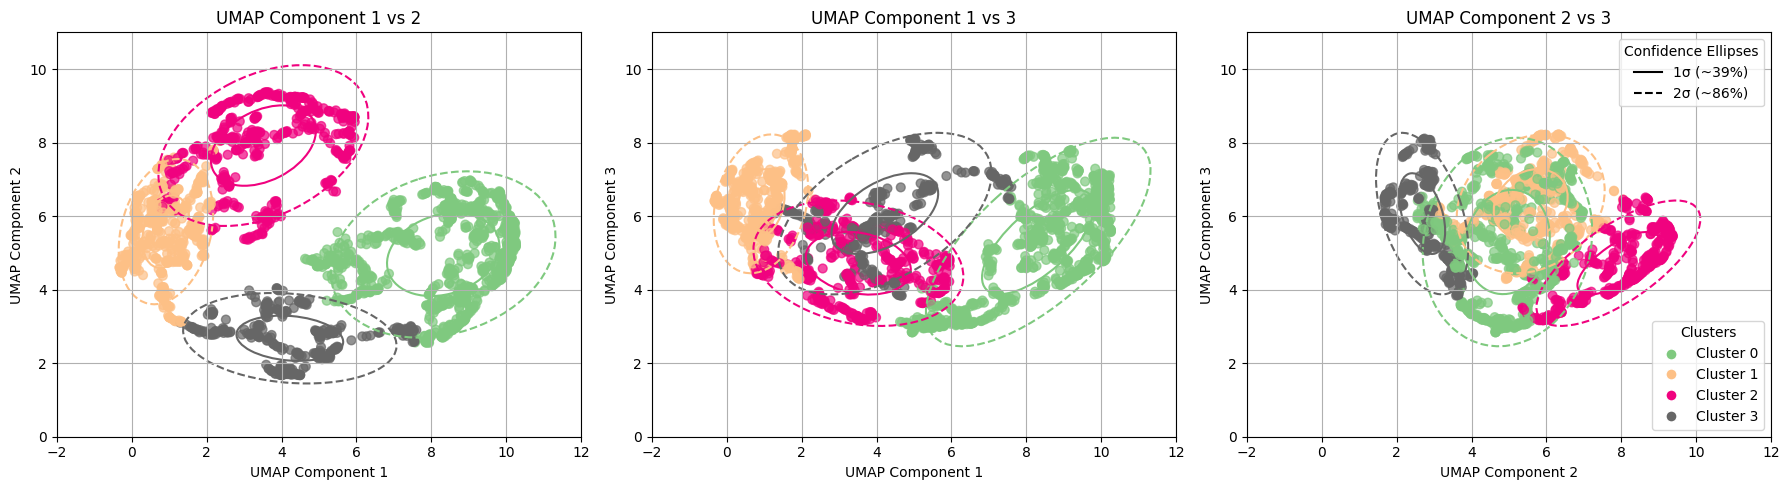

In [28]:
# Define component pairs for plotting
component_pairs = [(0, 1), (0, 2), (1, 2)]
titles = [
    "UMAP Component 1 vs 2",
    "UMAP Component 1 vs 3",
    "UMAP Component 2 vs 3"
]

def plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, colors):

    std_levels = [1, 2]
    chi2_vals = [chi2.ppf(0.3935, df=2), chi2.ppf(0.8647, df=2)]
    scales = [np.sqrt(val) for val in chi2_vals]

    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        if covar.ndim == 1:  # spherical
            cov = np.diag(covar)
        elif covar.ndim == 2:  # full or tied
            cov = covar
        else:
            continue

        # Project to 2D
        sub_cov = cov[np.ix_([comp_x, comp_y], [comp_x, comp_y])]
        sub_mean = mean[[comp_x, comp_y]]

        # Eigen decomposition
        vals, vecs = np.linalg.eigh(sub_cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        for scale, std in zip(scales, std_levels):
            width, height = 2 * scale * np.sqrt(vals)

            if std == 1:
                linestyle = '-'
            elif std == 2:
                linestyle = '--'
            else:
                linestyle = ':'

            ellipse = Ellipse(
                sub_mean, width, height, angle=theta,
                edgecolor=colors[i], facecolor='none', lw=1.5, linestyle=linestyle
            )
            ax.add_patch(ellipse)

# round the global min and max to the upper/lower integers, so all plot have the same limits
x_vals = []
y_vals = []
for comp_x, comp_y in component_pairs:
    x_vals.extend(X_umap[:, comp_x])
    y_vals.extend(X_umap[:, comp_y])
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)
# Round to nearest  boundaries
x_min = np.floor(x_min) -1
x_max = np.ceil(x_max) +1
y_min = np.floor(y_min) -1
y_max = np.ceil(y_max) +1

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (comp_x, comp_y) in enumerate(component_pairs):
    ax = axes[i]
    scatter = ax.scatter(
        X_umap[:, comp_x], X_umap[:, comp_y],
        c=gmm_labels, cmap=custom_cmap, s=40, alpha=0.7
    )
    ax.set_xlabel(f'UMAP Component {comp_x + 1}')
    ax.set_ylabel(f'UMAP Component {comp_y + 1}')
    ax.set_title(titles[i])
    ax.grid(True)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Plot GMM ellipses
    plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, accent_colors)

# Add legend to the last plot
custom_lines = [
    Line2D([0], [0], color='black', lw=1.5, linestyle='-'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
    Line2D([0], [0], color='black', lw=1.5, linestyle=':')
]
confidence_legend = axes[-1].legend(custom_lines, ['1σ (~39%)', '2σ (~86%)'], loc="upper right", title="Confidence Ellipses")

# Add first legend for confidence ellipses
axes[-1].add_artist(confidence_legend) 

# Create second legend for clusters
cluster_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=accent_colors[i], markersize=8)
    for i in range(K)
]
cluster_legend = axes[-1].legend(handles=cluster_handles, loc='lower right', title="Clusters")


plt.tight_layout()
plt.show()

In [29]:
# Print percentage of data points in each cluster
cluster_counts = pd.Series(gmm_labels).value_counts(normalize=True) * 100
print("\n Percentage of data points in each cluster:")
for cluster_id, percentage in cluster_counts.sort_index().items():
    print(f"Cluster {cluster_id}: {percentage:.2f}%")


 Percentage of data points in each cluster:
Cluster 0: 39.39%
Cluster 1: 22.10%
Cluster 2: 22.15%
Cluster 3: 16.37%


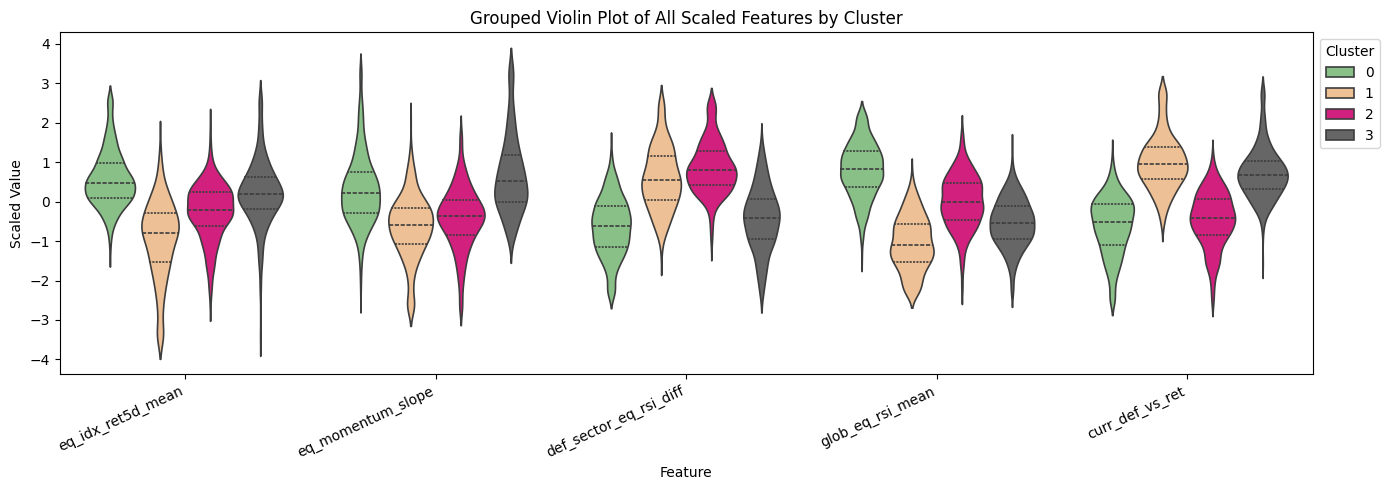

In [30]:
df_interpret = pd.DataFrame(scaled, columns=df_pivot_clean.columns, index=df_pivot_clean.index)
# Assign cluster labels
df_interpret['Cluster'] = gmm_labels

# Melt the dataframe to long format for seaborn
df_melted = df_interpret.reset_index().melt(id_vars=['Cluster'], 
                                              value_vars=df_interpret.columns,
                                              var_name='Feature', 
                                              value_name='Scaled Value')
# Create grouped violin plot
plt.figure(figsize=(14, 5))
sns.violinplot(
    data=df_melted,
    x='Feature',
    y='Scaled Value',
    hue='Cluster',
    palette=cluster_palette,
    split=False,        # Merge both clusters' violins in one shape if applicable
    inner='quartile',  # Show quartiles instead of full box
    linewidth=1.2
)

plt.title('Grouped Violin Plot of All Scaled Features by Cluster')
plt.ylabel('Scaled Value')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()


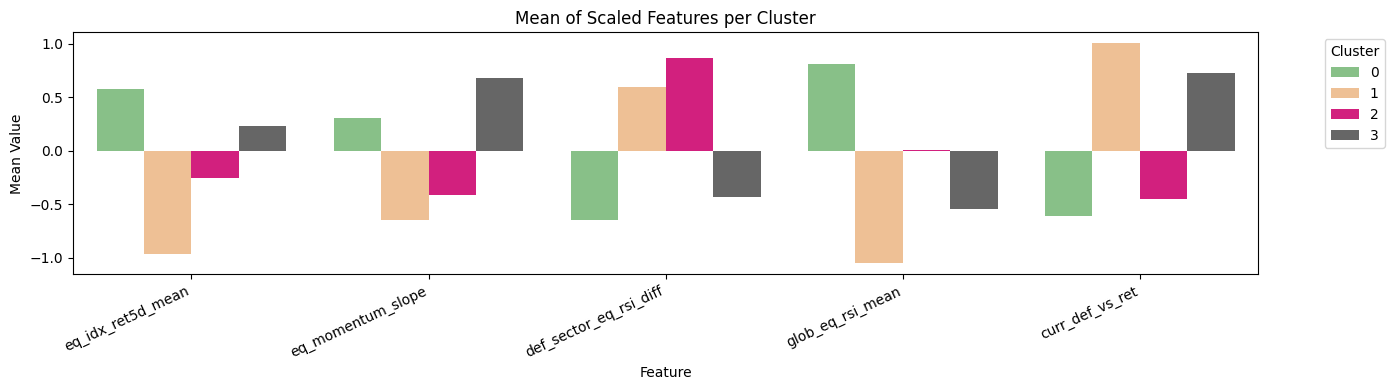

In [31]:
# Calculate mean value per feature per cluster
mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 4))
sns.barplot(x='Feature', y='Mean', hue='Cluster', data=melted, palette=cluster_palette)

plt.title('Mean of Scaled Features per Cluster')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()

# green bull todo
# yellow bear todo
# pink neutral-bearish US, global neutral, high defensive, low currency defensive
# grey bull US, strong momentum us, low defensive, bearish global, high currency defensive (strong dollar)

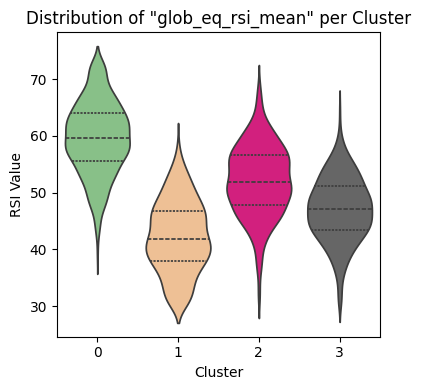

In [32]:
# To interpret RSI: must be no scaled
# RSI (Relative Strength Index) is a momentum oscillator that measures the speed and change of price

# RSI above 50 suggests bullish momentum; below 50 suggests bearish momentum.

# RSI > 70 → Asset may be overbought (potential for a price drop).
# RSI < 30 → Asset may be oversold (potential for a price rise).

# Limitations of RSI
# False Signals: Especially in trending markets, RSI can stay in overbought/oversold zones for extended periods.
# Lagging Indicator: RSI reflects past price action, not future movement.

df_interpret_no_sca = pd.DataFrame(df_pivot_clean, columns=df_pivot_clean.columns, index=df_pivot_clean.index)
df_interpret_no_sca['Cluster'] = gmm_labels

plt.figure(figsize=(4, 4))
sns.violinplot(
    x='Cluster',
    y='glob_eq_rsi_mean',
    hue='Cluster',  # Explicitly assign hue
    data=df_interpret_no_sca,
    palette=cluster_palette,
    inner='quartile',
    legend=False    # Prevent duplicate legend
)

plt.title(f'Distribution of \"{'glob_eq_rsi_mean'}\" per Cluster')
plt.xlabel('Cluster')
plt.ylabel('RSI Value')
plt.tight_layout()
plt.show()

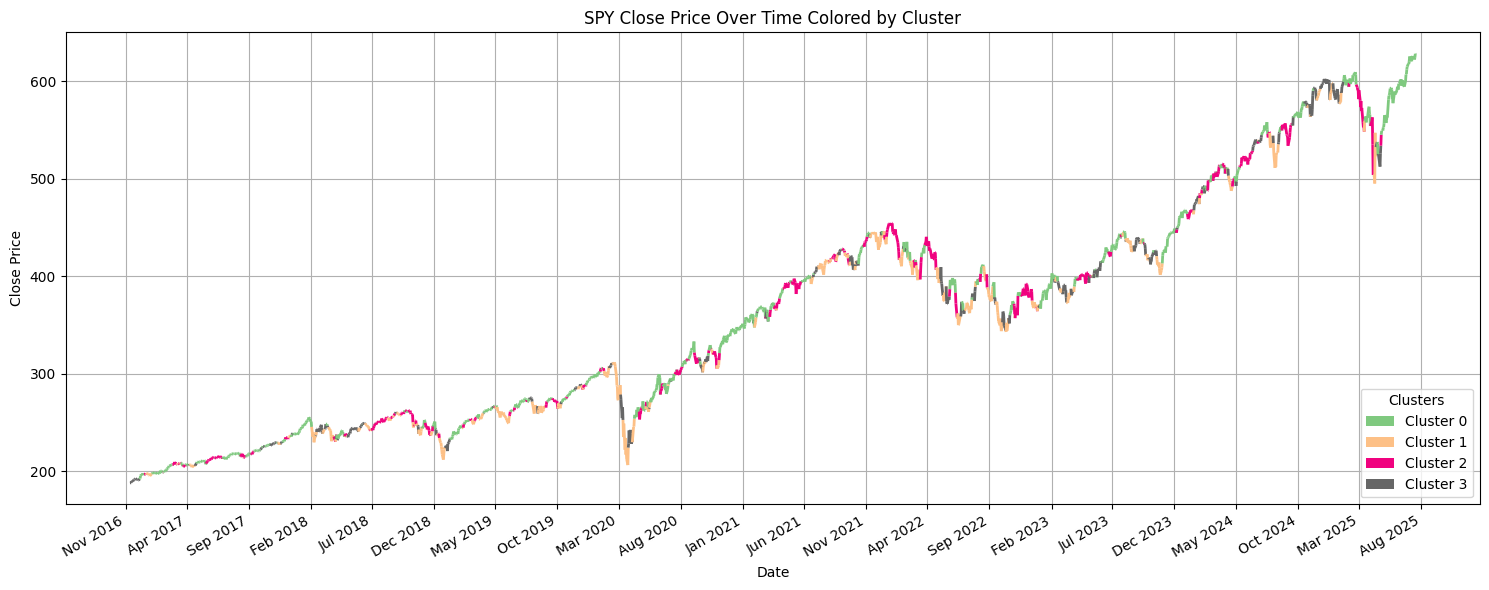

In [33]:
req = StockBarsRequest(
    symbol_or_symbols = 'SPY',
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date, 
    end = last_date,                                     
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_2_plot = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_2_plot = df_2_plot.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs
# remove first days that do not have cluster
df_2_plot =  df_2_plot[len(df_2_plot)-len(df_pivot_clean):]

# Merge cluster labels into df_2_plot
df_with_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = df_pivot_clean.copy()
df_time_clustered['Cluster'] = gmm_labels
df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

df_with_clusters['Cluster'] = df_time_clustered.loc[df_2_plot.index, 'Cluster'].values

# Prepare data for colored line segments
dates = df_with_clusters.index
close_prices = df_with_clusters['close'].values
clusters = df_with_clusters['Cluster'].values

# Create line segments between consecutive points
points = np.array([dates, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Assign colors based on clusters (normalize for color mapping)
colors = clusters[:-1]  # Use starting point's cluster for each segment
cmap = plt.get_cmap(custom_cmap)  # Choose a categorical colormap
norm = plt.Normalize(min(clusters), max(clusters))

# Convert datetime index to Matplotlib's float format
date_nums = mdates.date2num(dates)
# Create line segments with numeric date values
points = np.array([date_nums, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(colors)
lc.set_linewidth(2)

# Plot with colored lines for clusters using LineCollection
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc)
ax.autoscale()
ax.set_title("SPY Close Price Over Time Colored by Cluster")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.grid(True)

# Format month and year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

fig.autofmt_xdate()  # Auto-rotate labels for better visibility

# Build a legend for discrete clusters
unique_clusters = np.unique(clusters)
legend_elements = [Patch(facecolor=cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters]
ax.legend(handles=legend_elements, loc="lower right", title="Clusters")


plt.tight_layout()
plt.show()